# Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from os import path

root_path = "/content/drive/MyDrive/DFS/pu/thesis/the_new_one"

survival_path = path.join(root_path, "survival")
dataset_path = path.join(survival_path, "data")

aspect_path = path.join(root_path, "data", "df_aspect.csv")
augment_aspect_path = path.join(root_path, "data", "df_with_aspect_sentiment.csv")

!ls "$dataset_path"

comment.zip		       df_final.csv	   df_numeric.csv
df_aspect_analysis_expand.csv  df_final_kmean.csv  pu.csv


In [4]:
zip_path = path.join(dataset_path, "comment.zip")

!unzip $zip_path

Archive:  /content/drive/MyDrive/DFS/pu/thesis/the_new_one/survival/data/comment.zip
   creating: comment/
   creating: comment/1/
  inflating: comment/1/data.out      
  inflating: comment/1/links.in      
   creating: comment/2/
  inflating: comment/2/links.in      
  inflating: comment/2/data.out      


# Load data

In [5]:
import pandas as pd

aspect_df = pd.read_csv(aspect_path)
augment_df = pd.read_csv(augment_aspect_path)

aspect_df = pd.concat([aspect_df, augment_df])

closed_place = list(aspect_df[aspect_df['status'] == 'CLOSED_TEMPORARILY'].place_id.unique())

aspect_df = aspect_df[[
  'place_id',
  'overall_rating'	,
  'price'	,
  'review_time',
  'comment'	,
  'area',
  'a_food',
  'a_service',
  'a_atmosphere'
]]

aspect_df = aspect_df.rename(columns={
  'overall_rating': 'rating',
  'review_time': 'date',
  'comment': 'text'
})

aspect_df['date'] = pd.to_datetime(aspect_df['date'], format='%Y-%m-%d')
aspect_df['date'] = aspect_df['date'].dt.strftime('%m,%Y')

price_onehot = {
    '1-100.000': 0,
    '1-200.000': 0,

    'Vừa': 1,
    '100-200': 1,
    '100-300': 1,
    '200-300': 1,

    '200-400': 2,
    '300-400': 2,
    'Trên': 2,

    'Đắt': 3,
    '400-500': 3,
    '500-600': 3
}

aspect_df['price'] = aspect_df['price'].map(price_onehot)
most_popular = aspect_df['price'].value_counts().keys()[0]
aspect_df['price'] = aspect_df['price'].fillna(most_popular)

for place_id, group in aspect_df.groupby('place_id'):
  most_price_group = group.price.value_counts().keys()[0]
  aspect_df.loc[group.index, 'price'] = most_price_group

aspect_df

,place_id,rating,price,date,text,area,a_food,a_service,a_atmosphere
0,ChIJNd_JkGIpdTERXRtR4acBq-w,4.4,1.0,"01,2024",Ngồi chờ 30’ xong nhân viên ra báo bánh bị hư ...,Tân Bình,2.0,1.0,1.0
1,ChIJNd_JkGIpdTERXRtR4acBq-w,4.4,1.0,"07,2023",Pizza ngon phục vụ tận tình không gian thoughả...,Tân Bình,5.0,5.0,5.0
2,ChIJNd_JkGIpdTERXRtR4acBq-w,4.4,1.0,"08,2023",Đây là cái bánh pizza phô mai bên phan huy ích...,Tân Bình,1.0,4.0,4.0
3,ChIJNd_JkGIpdTERXRtR4acBq-w,4.4,1.0,"01,2023",Ngon nhưng web Order hay bị lag nên khó đặt qu...,Tân Bình,5.0,4.0,3.0
4,ChIJNd_JkGIpdTERXRtR4acBq-w,4.4,1.0,"01,2023",Pizza ăn ngon Không gian rộng rãi thougháng mát,Tân Bình,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...
8321,ChIJKw5ogJwpdTERm3eYnSlmsnw,4.7,1.0,"01,2023",Đề nghị quản lý nhà hàng nên xem xét lại cách ...,Gò Vấp,3.0,1.0,1.0
8322,ChIJVVVVVTwqdTERRmcHe-hzkms,4.5,1.0,"01,2023",Dạ nay ăn xong tô mì cay thì gặp them này,Hóc Môn,4.0,1.0,4.0
8323,ChIJN1syps8vdTERs5a9qK1_OBg,4.7,1.0,"09,2022",đắt xắt ra miếng từ món ăn chất lượng đến dịch...,Tân Phú,3.0,3.0,5.0
8324,ChIJN1syps8vdTERs5a9qK1_OBg,4.7,1.0,"10,2024",CB 199k,Tân Phú,5.0,5.0,4.0


In [6]:
id_mapping = {}

for idx, row in aspect_df.iterrows():
  if row['place_id'] not in id_mapping:
    id_mapping[row['place_id']] = {
        'area': row['area'],
        'price': row['price']
      }

id_mapping

{'ChIJNd_JkGIpdTERXRtR4acBq-w': {'area': 'Tân Bình', 'price': 1.0},
 'ChIJwSV2FxgpdTER77c8n-d267I': {'area': 'Tân Bình', 'price': 1.0},
 'ChIJ0aoMnHUpdTERWGMh6xHpbfI': {'area': 'Tân Bình', 'price': 1.0},
 'ChIJE9MrAQApdTER7RqJFTDUv4Y': {'area': 'Tân Bình', 'price': 1.0},
 'ChIJRwBkqzEpdTEROe84CeM0YCA': {'area': 'Tân Bình', 'price': 1.0},
 'ChIJz6mOIn0pdTERC7A6Sy-cvOw': {'area': 'Tân Bình', 'price': 1.0},
 'ChIJR_EFmoQrdTERDIyI_kD5iZE': {'area': 'Tân Phú', 'price': 1.0},
 'ChIJJYHR3rYpdTER_jYcmgm3uSE': {'area': 'Tân Bình', 'price': 0.0},
 'ChIJtU8HKZMrdTERgCrRqDvG7CA': {'area': 'Quận 12', 'price': 1.0},
 'ChIJJb5MU78rdTEREZdkS2MeXYc': {'area': 'Quận 12', 'price': 1.0},
 'ChIJ7aztXtQrdTERZVwNHKqUkTc': {'area': 'Quận 12', 'price': 1.0},
 'ChIJI-f7wO8rdTERXjlvq5anOL0': {'area': 'Quận 12', 'price': 1.0},
 'ChIJp5QqWhIrdTERpsNZOZ28Ee8': {'area': 'Tân Phú', 'price': 1.0},
 'ChIJ5eW3UwArdTER1_H6kwW816M': {'area': 'Tân Phú', 'price': 1.0},
 'ChIJtTbYgV8pdTERM1NGRUwZMlk': {'area': 'Tân Phú', 'pr

In [7]:
import json, os
import pandas as pd
from datetime import datetime, timedelta

df = {
    "place_id": [],
    "area": [],
    'price': [],
    'rating': [],
    "date": [],
    'text': [],
}

for num_part in os.listdir("./comment"):

  part_path = os.path.join("./comment", num_part)

  with open(os.path.join(part_path, "data.out"), "r") as f:
    lines_out = f.readlines()

  print(num_part, len(lines_out))

  for data in lines_out:
    data_json = json.loads(data)

    for review in data_json['reviews']:

      df["place_id"].append(data_json['place_id'])

      review_time = review["time"]

      if "," not in review_time:
        num, offset, _ = review_time.split(" ")

        if offset == "tuần":
          review_time = datetime.now() - timedelta(weeks=int(num))
        elif offset == "tháng":
          review_time = datetime.now() - timedelta(days=int(num) * 30)

        review_time = review_time.strftime("%m,%Y")

      df["date"].append(review_time)
      df["text"].append(review['comment'])
      df["rating"].append(data_json['star'])

      df['price'].append(id_mapping[data_json['place_id']]['price'])
      df["area"].append(id_mapping[data_json['place_id']]['area'])

df = pd.DataFrame(df)
df['date'] = pd.to_datetime(df['date'], format='%m,%Y')
df['date'] = df['date'].dt.strftime('%m,%Y')

df

1 157
2 158


,place_id,area,price,rating,date,text
0,ChIJNd_JkGIpdTERXRtR4acBq-w,Tân Bình,1.0,4.4,"11,2024","Cỡ 9 có thể 2ng ăn ,sức ăn mạnh chắc 1 người ăn."
1,ChIJNd_JkGIpdTERXRtR4acBq-w,Tân Bình,1.0,4.4,"01,2024",Ngồi chờ 30’ xong nhân viên ra báo bánh bị hư ...
2,ChIJNd_JkGIpdTERXRtR4acBq-w,Tân Bình,1.0,4.4,"01,2024","""Domino"" có thể đề cập đến nhiều thứ khác nhau..."
3,ChIJNd_JkGIpdTERXRtR4acBq-w,Tân Bình,1.0,4.4,"01,2024","Giao hàng quá tệ, đặt từ 6h tối đến 7h tối mới..."
4,ChIJNd_JkGIpdTERXRtR4acBq-w,Tân Bình,1.0,4.4,"01,2024",Các bạn ở Domino này làm việc hơi chậm.\nHình ...
...,...,...,...,...,...,...
51740,ChIJd_2LSKMrdTERlUNKSqVWMFs,Hóc Môn,0.0,4.7,"04,2024",Không gian: khá rộng rãi và hoành tráng.\n\nMộ...
51741,ChIJd_2LSKMrdTERlUNKSqVWMFs,Hóc Môn,0.0,4.7,"04,2024",Được rồi 👌 …
51742,ChIJd_2LSKMrdTERlUNKSqVWMFs,Hóc Môn,0.0,4.7,"04,2024",Để đó
51743,ChIJd_2LSKMrdTERlUNKSqVWMFs,Hóc Môn,0.0,4.7,"04,2024",ĐẾN


In [8]:
full_df = pd.concat([df, aspect_df])
full_df = full_df.drop(columns=['a_food', 'a_service', 'a_atmosphere'])

full_df.drop_duplicates(inplace=True)
full_df.reset_index(drop=True, inplace=True)

full_df['date'] = pd.to_datetime(full_df['date'], format='%m,%Y')

for place_id, group in full_df.groupby('place_id'):
  most_price_group = group.price.value_counts().keys()[0]
  full_df.loc[group.index, 'price'] = most_price_group

for place_id, group in full_df.groupby('place_id'):
  most_rating_group = group.rating.value_counts().keys()[0]
  full_df.loc[group.index, 'rating'] = most_rating_group

full_df

,place_id,area,price,rating,date,text
0,ChIJNd_JkGIpdTERXRtR4acBq-w,Tân Bình,1.0,4.4,2024-11-01,"Cỡ 9 có thể 2ng ăn ,sức ăn mạnh chắc 1 người ăn."
1,ChIJNd_JkGIpdTERXRtR4acBq-w,Tân Bình,1.0,4.4,2024-01-01,Ngồi chờ 30’ xong nhân viên ra báo bánh bị hư ...
2,ChIJNd_JkGIpdTERXRtR4acBq-w,Tân Bình,1.0,4.4,2024-01-01,"""Domino"" có thể đề cập đến nhiều thứ khác nhau..."
3,ChIJNd_JkGIpdTERXRtR4acBq-w,Tân Bình,1.0,4.4,2024-01-01,"Giao hàng quá tệ, đặt từ 6h tối đến 7h tối mới..."
4,ChIJNd_JkGIpdTERXRtR4acBq-w,Tân Bình,1.0,4.4,2024-01-01,Các bạn ở Domino này làm việc hơi chậm.\nHình ...
...,...,...,...,...,...,...
67048,ChIJKw5ogJwpdTERm3eYnSlmsnw,Gò Vấp,1.0,4.7,2023-01-01,Đề nghị quản lý nhà hàng nên xem xét lại cách ...
67049,ChIJVVVVVTwqdTERRmcHe-hzkms,Hóc Môn,1.0,4.5,2023-01-01,Dạ nay ăn xong tô mì cay thì gặp them này
67050,ChIJN1syps8vdTERs5a9qK1_OBg,Tân Phú,1.0,4.7,2022-09-01,đắt xắt ra miếng từ món ăn chất lượng đến dịch...
67051,ChIJN1syps8vdTERs5a9qK1_OBg,Tân Phú,1.0,4.7,2024-10-01,CB 199k


In [9]:
from itertools import count
from tqdm.auto import tqdm
import re

list_obser = []
for place_id, group in tqdm(full_df.groupby('place_id')):
    data = {
        'place_id': place_id,
    }

    observer_date = None
    is_closed = False

    for review, date in zip(group['text'], group['date']):
      for keyword in ["closed", "shut down", "not open", "another location", "đóng cửa", "không mở", "đổi vị trí", "chuyển vị trí", "giải thể"]:
        if any([i in review.lower() for i in ["gần", "giờ", "sớm", "vào", "máy", "sắp", "giao", "lịch", "đang", "lại mở", "tiếng"]]) or re.search(r"[\dh]{2,}\b", review.lower()) is not None:
          continue

        if keyword not in str(review).lower():
          continue

        # print(keyword)
        # print(review)
        # print()
        is_closed = True

        if observer_date is None or date < observer_date:
            observer_date = date

        break

    if not is_closed and place_id in closed_place:
      is_closed = True

    if observer_date is None:
        observer_date = group['date'].max()

    data['closed'] = is_closed
    data['observer_date'] = observer_date

    list_obser.append(data)

df_obser = pd.DataFrame(list_obser)
df_obser['observer_date'] = pd.to_datetime(df_obser['observer_date'], format='%m,%Y')
df_obser

  0%|          | 0/315 [00:00<?, ?it/s]

,place_id,closed,observer_date
0,ChIJ-03wYwMrdTER-1NElD9XLEg,False,2024-11-01
1,ChIJ-0VLn8sudTERGw-MW05RZS4,False,2025-01-01
2,ChIJ-9b8dxcpdTERjMs-TwixO_0,False,2025-01-01
3,ChIJ-ZE4DgApdTERS0vMWv7kdJQ,False,2025-01-01
4,ChIJ-b_0ApQpdTEReFcT97UuxpQ,False,2024-12-01
...,...,...,...
310,ChIJzUFM6ckpdTERbKUvZPYkiS8,False,2024-12-01
311,ChIJzVsCV7UrdTERnW90-6kuG0w,False,2025-01-01
312,ChIJzYZL4ZwpdTERh8jCEz4sGTw,False,2024-10-01
313,ChIJz_KhzQkvdTERgivBct5H2SA,False,2025-01-01


In [10]:
for place_id, group in full_df.groupby('place_id'):
  min_open_date = group['date'].min()
  full_df.loc[group.index, 'open_date'] = min_open_date

for idx, row in df_obser.iterrows():
  ids = full_df[full_df['place_id'] == row['place_id']].index

  full_df.loc[ids, 'closed'] = row['closed']
  full_df.loc[ids, 'observer_date'] = row['observer_date']

full_df['observer_date'] = pd.to_datetime(full_df['observer_date'], format='%m,%Y')
full_df['open_date'] = pd.to_datetime(full_df['open_date'], format='%m,%Y')

len(full_df[full_df['closed']].place_id.unique())

17

In [11]:
full_df

,place_id,area,price,rating,date,text,open_date,closed,observer_date
0,ChIJNd_JkGIpdTERXRtR4acBq-w,Tân Bình,1.0,4.4,2024-11-01,"Cỡ 9 có thể 2ng ăn ,sức ăn mạnh chắc 1 người ăn.",2019-03-01,False,2024-11-01
1,ChIJNd_JkGIpdTERXRtR4acBq-w,Tân Bình,1.0,4.4,2024-01-01,Ngồi chờ 30’ xong nhân viên ra báo bánh bị hư ...,2019-03-01,False,2024-11-01
2,ChIJNd_JkGIpdTERXRtR4acBq-w,Tân Bình,1.0,4.4,2024-01-01,"""Domino"" có thể đề cập đến nhiều thứ khác nhau...",2019-03-01,False,2024-11-01
3,ChIJNd_JkGIpdTERXRtR4acBq-w,Tân Bình,1.0,4.4,2024-01-01,"Giao hàng quá tệ, đặt từ 6h tối đến 7h tối mới...",2019-03-01,False,2024-11-01
4,ChIJNd_JkGIpdTERXRtR4acBq-w,Tân Bình,1.0,4.4,2024-01-01,Các bạn ở Domino này làm việc hơi chậm.\nHình ...,2019-03-01,False,2024-11-01
...,...,...,...,...,...,...,...,...,...
67048,ChIJKw5ogJwpdTERm3eYnSlmsnw,Gò Vấp,1.0,4.7,2023-01-01,Đề nghị quản lý nhà hàng nên xem xét lại cách ...,2021-01-01,False,2025-01-01
67049,ChIJVVVVVTwqdTERRmcHe-hzkms,Hóc Môn,1.0,4.5,2023-01-01,Dạ nay ăn xong tô mì cay thì gặp them này,2018-03-01,False,2025-01-01
67050,ChIJN1syps8vdTERs5a9qK1_OBg,Tân Phú,1.0,4.7,2022-09-01,đắt xắt ra miếng từ món ăn chất lượng đến dịch...,2017-10-01,False,2024-12-01
67051,ChIJN1syps8vdTERs5a9qK1_OBg,Tân Phú,1.0,4.7,2024-10-01,CB 199k,2017-10-01,False,2024-12-01


In [12]:
pd.options.mode.copy_on_write = True

competitors_df = full_df[['area', 'place_id', 'observer_date', 'open_date']]
competitors_df.drop_duplicates(inplace=True)
competitors_df.reset_index(drop=True, inplace=True)

for idx, res in competitors_df.iterrows():
  n_months = (res['observer_date'].year - res['open_date'].year) * 12 + (res['observer_date'].month - res['open_date'].month) + 1
  competitors_df.loc[idx, 'n_months'] = n_months

competitors_df['n_months'] = competitors_df['n_months'].astype(int)
competitors_df

,area,place_id,observer_date,open_date,n_months
0,Tân Bình,ChIJNd_JkGIpdTERXRtR4acBq-w,2024-11-01,2019-03-01,69
1,Tân Bình,ChIJwSV2FxgpdTER77c8n-d267I,2024-11-01,2023-11-01,13
2,Tân Bình,ChIJ0aoMnHUpdTERWGMh6xHpbfI,2025-01-01,2019-11-01,63
3,Tân Bình,ChIJE9MrAQApdTER7RqJFTDUv4Y,2025-01-01,2024-03-01,11
4,Tân Bình,ChIJRwBkqzEpdTEROe84CeM0YCA,2024-12-01,2022-02-01,35
...,...,...,...,...,...
310,Quận 12,ChIJLdqfCwYpdTERHe9GR3p-jmg,2025-01-01,2021-03-01,47
311,Quận 12,ChIJ82iVue4pdTERVPTlYjDcsLc,2025-01-01,2023-11-01,15
312,Quận 12,ChIJS12LpAopdTERo2Nr0jjtIyY,2023-10-01,2020-10-01,37
313,Hóc Môn,ChIJL5Yy0HMqdTER6OksGCJHPJU,2024-07-01,2017-06-01,86


In [13]:
competitors_df.groupby('area').size().sort_values(ascending=False)

,0
area,
Tân Bình,102
Gò Vấp,91
Tân Phú,57
Quận 12,28
Phú Nhuận,12
Hóc Môn,9
Bình Tân,8
Quận 10,4
Quận 11,3


In [14]:
import numpy as np

def get_competitors(group):
  min_open_date = group['open_date'].min()
  max_closed_date = group['observer_date'].max()
  n_months = (max_closed_date.year - min_open_date.year) * 12 + (max_closed_date.month - min_open_date.month) + 1

  review_month_list = np.zeros((len(group), n_months + 1))

  # Init month matrix
  for idx_res, (_, res_data) in enumerate(group.iterrows()):
      month_exists = [1] * res_data['n_months']
      start_idx = (res_data['open_date'].year - min_open_date.year)*12 + (res_data['open_date'].month - min_open_date.month) + 1

      review_month_list[idx_res, start_idx:start_idx + res_data['n_months']] = month_exists
      review_month_list[idx_res, 0] = res_data['n_months']

  # Calc competitors
  for idx_res, (idx_row, res_data) in enumerate(group.iterrows()):
      other_review_month_list = np.delete(review_month_list, idx_res, axis=0)
      competitors = np.sum(other_review_month_list[:, 1:], axis=0)

      competitors = np.sum(review_month_list[idx_res, 1:] * competitors)  / review_month_list[idx_res, 0]

      group.loc[idx_row, 'competitors'] = competitors

  return group[['place_id', 'competitors']]

competitors_df = competitors_df.groupby('area').apply(get_competitors, include_groups=False).reset_index(drop=True)
competitors_df

,place_id,competitors
0,ChIJWWh2r4QrdTERNhic2XrynEo,2.603960
1,ChIJpZaeBsMtdTERSL4lXF6yS2E,5.800000
2,ChIJbQwInRotdTERCZWL1AgwvtI,3.983051
3,ChIJi6-umR0rdTERQKFcviMB_yI,5.000000
4,ChIJTf6XQwAtdTERZHa43D-l738,5.571429
...,...,...
310,ChIJ5ZEzUZQvdTERE1BFjYO8RlM,45.631579
311,ChIJP8NIb5EtdTERq2c6h086x0A,36.220000
312,ChIJjSaA6KUudTERnglIqFuPyPI,15.085714
313,ChIJO2UZgaoudTERZACuE_jh2F0,31.440000


# data characteristic
- business_id
- avg number of competitors per month
- price level
- avg review length to date

In [15]:
analysis_df = full_df.merge(competitors_df, on='place_id', how='left')
analysis_df.drop(columns=['text', 'date'], inplace=True)

analysis_df.drop_duplicates(inplace=True)
analysis_df.reset_index(drop=True, inplace=True)

analysis_df

,place_id,area,price,rating,open_date,closed,observer_date,competitors
0,ChIJNd_JkGIpdTERXRtR4acBq-w,Tân Bình,1.0,4.4,2019-03-01,False,2024-11-01,68.347826
1,ChIJwSV2FxgpdTER77c8n-d267I,Tân Bình,1.0,5.0,2023-11-01,False,2024-11-01,92.000000
2,ChIJ0aoMnHUpdTERWGMh6xHpbfI,Tân Bình,1.0,4.4,2019-11-01,False,2025-01-01,71.619048
3,ChIJE9MrAQApdTER7RqJFTDUv4Y,Tân Bình,1.0,4.9,2024-03-01,False,2025-01-01,88.454545
4,ChIJRwBkqzEpdTEROe84CeM0YCA,Tân Bình,1.0,4.3,2022-02-01,False,2024-12-01,81.171429
...,...,...,...,...,...,...,...,...
310,ChIJLdqfCwYpdTERHe9GR3p-jmg,Quận 12,0.0,4.6,2021-03-01,False,2025-01-01,17.446809
311,ChIJ82iVue4pdTERVPTlYjDcsLc,Quận 12,1.0,4.9,2023-11-01,False,2025-01-01,22.533333
312,ChIJS12LpAopdTERo2Nr0jjtIyY,Quận 12,1.0,3.9,2020-10-01,True,2023-10-01,14.378378
313,ChIJL5Yy0HMqdTER6OksGCJHPJU,Hóc Môn,1.0,4.1,2017-06-01,False,2024-07-01,4.744186


In [16]:
for idx, row in analysis_df.iterrows():
  analysis_df.loc[idx, 'review_length'] = full_df[full_df['place_id'] == row['place_id']]['text'].apply(len).mean()

analysis_df

,place_id,area,price,rating,open_date,closed,observer_date,competitors,review_length
0,ChIJNd_JkGIpdTERXRtR4acBq-w,Tân Bình,1.0,4.4,2019-03-01,False,2024-11-01,68.347826,83.080925
1,ChIJwSV2FxgpdTER77c8n-d267I,Tân Bình,1.0,5.0,2023-11-01,False,2024-11-01,92.000000,132.147541
2,ChIJ0aoMnHUpdTERWGMh6xHpbfI,Tân Bình,1.0,4.4,2019-11-01,False,2025-01-01,71.619048,115.084416
3,ChIJE9MrAQApdTER7RqJFTDUv4Y,Tân Bình,1.0,4.9,2024-03-01,False,2025-01-01,88.454545,86.270492
4,ChIJRwBkqzEpdTEROe84CeM0YCA,Tân Bình,1.0,4.3,2022-02-01,False,2024-12-01,81.171429,164.186567
...,...,...,...,...,...,...,...,...,...
310,ChIJLdqfCwYpdTERHe9GR3p-jmg,Quận 12,0.0,4.6,2021-03-01,False,2025-01-01,17.446809,110.224852
311,ChIJ82iVue4pdTERVPTlYjDcsLc,Quận 12,1.0,4.9,2023-11-01,False,2025-01-01,22.533333,175.264706
312,ChIJS12LpAopdTERo2Nr0jjtIyY,Quận 12,1.0,3.9,2020-10-01,True,2023-10-01,14.378378,100.167702
313,ChIJL5Yy0HMqdTER6OksGCJHPJU,Hóc Môn,1.0,4.1,2017-06-01,False,2024-07-01,4.744186,51.843750


In [17]:
# customer engagement per month
def cus_engagement(group, observer_date, open_date):
  n_months = (observer_date.year - open_date.year) * 12 + (observer_date.month - open_date.month) + 1

  engagement = group['a_food'].sum() + group['a_service'].sum() + group['a_atmosphere'].sum()
  return engagement / n_months

def avg_aspect(group, aspect):
  return group[aspect].mean()

for idx, row in analysis_df.iterrows():
  analysis_df.loc[idx, 'customer_engagement'] = cus_engagement(aspect_df[aspect_df['place_id'] == row['place_id']], row['observer_date'], row['open_date'])

analysis_df

,place_id,area,price,rating,open_date,closed,observer_date,competitors,review_length,customer_engagement
0,ChIJNd_JkGIpdTERXRtR4acBq-w,Tân Bình,1.0,4.4,2019-03-01,False,2024-11-01,68.347826,83.080925,5.985507
1,ChIJwSV2FxgpdTER77c8n-d267I,Tân Bình,1.0,5.0,2023-11-01,False,2024-11-01,92.000000,132.147541,79.000000
2,ChIJ0aoMnHUpdTERWGMh6xHpbfI,Tân Bình,1.0,4.4,2019-11-01,False,2025-01-01,71.619048,115.084416,4.825397
3,ChIJE9MrAQApdTER7RqJFTDUv4Y,Tân Bình,1.0,4.9,2024-03-01,False,2025-01-01,88.454545,86.270492,249.909091
4,ChIJRwBkqzEpdTEROe84CeM0YCA,Tân Bình,1.0,4.3,2022-02-01,False,2024-12-01,81.171429,164.186567,10.828571
...,...,...,...,...,...,...,...,...,...,...
310,ChIJLdqfCwYpdTERHe9GR3p-jmg,Quận 12,0.0,4.6,2021-03-01,False,2025-01-01,17.446809,110.224852,13.765957
311,ChIJ82iVue4pdTERVPTlYjDcsLc,Quận 12,1.0,4.9,2023-11-01,False,2025-01-01,22.533333,175.264706,29.133333
312,ChIJS12LpAopdTERo2Nr0jjtIyY,Quận 12,1.0,3.9,2020-10-01,True,2023-10-01,14.378378,100.167702,8.864865
313,ChIJL5Yy0HMqdTER6OksGCJHPJU,Hóc Môn,1.0,4.1,2017-06-01,False,2024-07-01,4.744186,51.843750,4.651163


In [18]:
# average number of reviews per month

def num_reviews(group, observer_date, open_date):
  n_months = (observer_date.year - open_date.year) * 12 + (observer_date.month - open_date.month) + 1

  return len(group['text']) / n_months

for idx, row in analysis_df.iterrows():
  analysis_df.loc[idx, 'num_reviews'] = num_reviews(full_df[full_df['place_id'] == row['place_id']], row['observer_date'], row['open_date'])

analysis_df

,place_id,area,price,rating,open_date,closed,observer_date,competitors,review_length,customer_engagement,num_reviews
0,ChIJNd_JkGIpdTERXRtR4acBq-w,Tân Bình,1.0,4.4,2019-03-01,False,2024-11-01,68.347826,83.080925,5.985507,2.507246
1,ChIJwSV2FxgpdTER77c8n-d267I,Tân Bình,1.0,5.0,2023-11-01,False,2024-11-01,92.000000,132.147541,79.000000,14.076923
2,ChIJ0aoMnHUpdTERWGMh6xHpbfI,Tân Bình,1.0,4.4,2019-11-01,False,2025-01-01,71.619048,115.084416,4.825397,2.444444
3,ChIJE9MrAQApdTER7RqJFTDUv4Y,Tân Bình,1.0,4.9,2024-03-01,False,2025-01-01,88.454545,86.270492,249.909091,33.272727
4,ChIJRwBkqzEpdTEROe84CeM0YCA,Tân Bình,1.0,4.3,2022-02-01,False,2024-12-01,81.171429,164.186567,10.828571,3.828571
...,...,...,...,...,...,...,...,...,...,...,...
310,ChIJLdqfCwYpdTERHe9GR3p-jmg,Quận 12,0.0,4.6,2021-03-01,False,2025-01-01,17.446809,110.224852,13.765957,3.595745
311,ChIJ82iVue4pdTERVPTlYjDcsLc,Quận 12,1.0,4.9,2023-11-01,False,2025-01-01,22.533333,175.264706,29.133333,4.533333
312,ChIJS12LpAopdTERo2Nr0jjtIyY,Quận 12,1.0,3.9,2020-10-01,True,2023-10-01,14.378378,100.167702,8.864865,4.351351
313,ChIJL5Yy0HMqdTER6OksGCJHPJU,Hóc Môn,1.0,4.1,2017-06-01,False,2024-07-01,4.744186,51.843750,4.651163,2.232558


In [19]:
analysis_df['survival_duration'] = analysis_df['observer_date'] - analysis_df['open_date']
analysis_df

,place_id,area,price,rating,open_date,closed,observer_date,competitors,review_length,customer_engagement,num_reviews,survival_duration
0,ChIJNd_JkGIpdTERXRtR4acBq-w,Tân Bình,1.0,4.4,2019-03-01,False,2024-11-01,68.347826,83.080925,5.985507,2.507246,2072 days
1,ChIJwSV2FxgpdTER77c8n-d267I,Tân Bình,1.0,5.0,2023-11-01,False,2024-11-01,92.000000,132.147541,79.000000,14.076923,366 days
2,ChIJ0aoMnHUpdTERWGMh6xHpbfI,Tân Bình,1.0,4.4,2019-11-01,False,2025-01-01,71.619048,115.084416,4.825397,2.444444,1888 days
3,ChIJE9MrAQApdTER7RqJFTDUv4Y,Tân Bình,1.0,4.9,2024-03-01,False,2025-01-01,88.454545,86.270492,249.909091,33.272727,306 days
4,ChIJRwBkqzEpdTEROe84CeM0YCA,Tân Bình,1.0,4.3,2022-02-01,False,2024-12-01,81.171429,164.186567,10.828571,3.828571,1034 days
...,...,...,...,...,...,...,...,...,...,...,...,...
310,ChIJLdqfCwYpdTERHe9GR3p-jmg,Quận 12,0.0,4.6,2021-03-01,False,2025-01-01,17.446809,110.224852,13.765957,3.595745,1402 days
311,ChIJ82iVue4pdTERVPTlYjDcsLc,Quận 12,1.0,4.9,2023-11-01,False,2025-01-01,22.533333,175.264706,29.133333,4.533333,427 days
312,ChIJS12LpAopdTERo2Nr0jjtIyY,Quận 12,1.0,3.9,2020-10-01,True,2023-10-01,14.378378,100.167702,8.864865,4.351351,1095 days
313,ChIJL5Yy0HMqdTER6OksGCJHPJU,Hóc Môn,1.0,4.1,2017-06-01,False,2024-07-01,4.744186,51.843750,4.651163,2.232558,2587 days


In [20]:
analysis_df

,place_id,area,price,rating,open_date,closed,observer_date,competitors,review_length,customer_engagement,num_reviews,survival_duration
0,ChIJNd_JkGIpdTERXRtR4acBq-w,Tân Bình,1.0,4.4,2019-03-01,False,2024-11-01,68.347826,83.080925,5.985507,2.507246,2072 days
1,ChIJwSV2FxgpdTER77c8n-d267I,Tân Bình,1.0,5.0,2023-11-01,False,2024-11-01,92.000000,132.147541,79.000000,14.076923,366 days
2,ChIJ0aoMnHUpdTERWGMh6xHpbfI,Tân Bình,1.0,4.4,2019-11-01,False,2025-01-01,71.619048,115.084416,4.825397,2.444444,1888 days
3,ChIJE9MrAQApdTER7RqJFTDUv4Y,Tân Bình,1.0,4.9,2024-03-01,False,2025-01-01,88.454545,86.270492,249.909091,33.272727,306 days
4,ChIJRwBkqzEpdTEROe84CeM0YCA,Tân Bình,1.0,4.3,2022-02-01,False,2024-12-01,81.171429,164.186567,10.828571,3.828571,1034 days
...,...,...,...,...,...,...,...,...,...,...,...,...
310,ChIJLdqfCwYpdTERHe9GR3p-jmg,Quận 12,0.0,4.6,2021-03-01,False,2025-01-01,17.446809,110.224852,13.765957,3.595745,1402 days
311,ChIJ82iVue4pdTERVPTlYjDcsLc,Quận 12,1.0,4.9,2023-11-01,False,2025-01-01,22.533333,175.264706,29.133333,4.533333,427 days
312,ChIJS12LpAopdTERo2Nr0jjtIyY,Quận 12,1.0,3.9,2020-10-01,True,2023-10-01,14.378378,100.167702,8.864865,4.351351,1095 days
313,ChIJL5Yy0HMqdTER6OksGCJHPJU,Hóc Môn,1.0,4.1,2017-06-01,False,2024-07-01,4.744186,51.843750,4.651163,2.232558,2587 days


In [21]:
aspect_df

,place_id,rating,price,date,text,area,a_food,a_service,a_atmosphere
0,ChIJNd_JkGIpdTERXRtR4acBq-w,4.4,1.0,"01,2024",Ngồi chờ 30’ xong nhân viên ra báo bánh bị hư ...,Tân Bình,2.0,1.0,1.0
1,ChIJNd_JkGIpdTERXRtR4acBq-w,4.4,1.0,"07,2023",Pizza ngon phục vụ tận tình không gian thoughả...,Tân Bình,5.0,5.0,5.0
2,ChIJNd_JkGIpdTERXRtR4acBq-w,4.4,1.0,"08,2023",Đây là cái bánh pizza phô mai bên phan huy ích...,Tân Bình,1.0,4.0,4.0
3,ChIJNd_JkGIpdTERXRtR4acBq-w,4.4,1.0,"01,2023",Ngon nhưng web Order hay bị lag nên khó đặt qu...,Tân Bình,5.0,4.0,3.0
4,ChIJNd_JkGIpdTERXRtR4acBq-w,4.4,1.0,"01,2023",Pizza ăn ngon Không gian rộng rãi thougháng mát,Tân Bình,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...
8321,ChIJKw5ogJwpdTERm3eYnSlmsnw,4.7,1.0,"01,2023",Đề nghị quản lý nhà hàng nên xem xét lại cách ...,Gò Vấp,3.0,1.0,1.0
8322,ChIJVVVVVTwqdTERRmcHe-hzkms,4.5,1.0,"01,2023",Dạ nay ăn xong tô mì cay thì gặp them này,Hóc Môn,4.0,1.0,4.0
8323,ChIJN1syps8vdTERs5a9qK1_OBg,4.7,1.0,"09,2022",đắt xắt ra miếng từ món ăn chất lượng đến dịch...,Tân Phú,3.0,3.0,5.0
8324,ChIJN1syps8vdTERs5a9qK1_OBg,4.7,1.0,"10,2024",CB 199k,Tân Phú,5.0,5.0,4.0


In [22]:
merged_df = pd.merge(
    aspect_df.drop(columns = ['rating', 'price', 'date', 'text', 'area']),
    analysis_df,
    on='place_id',
    how='right'
)
merged_df

,place_id,a_food,a_service,a_atmosphere,area,price,rating,open_date,closed,observer_date,competitors,review_length,customer_engagement,num_reviews,survival_duration
0,ChIJNd_JkGIpdTERXRtR4acBq-w,2.0,1.0,1.0,Tân Bình,1.0,4.4,2019-03-01,False,2024-11-01,68.347826,83.080925,5.985507,2.507246,2072 days
1,ChIJNd_JkGIpdTERXRtR4acBq-w,5.0,5.0,5.0,Tân Bình,1.0,4.4,2019-03-01,False,2024-11-01,68.347826,83.080925,5.985507,2.507246,2072 days
2,ChIJNd_JkGIpdTERXRtR4acBq-w,1.0,4.0,4.0,Tân Bình,1.0,4.4,2019-03-01,False,2024-11-01,68.347826,83.080925,5.985507,2.507246,2072 days
3,ChIJNd_JkGIpdTERXRtR4acBq-w,5.0,4.0,3.0,Tân Bình,1.0,4.4,2019-03-01,False,2024-11-01,68.347826,83.080925,5.985507,2.507246,2072 days
4,ChIJNd_JkGIpdTERXRtR4acBq-w,4.0,4.0,4.0,Tân Bình,1.0,4.4,2019-03-01,False,2024-11-01,68.347826,83.080925,5.985507,2.507246,2072 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18055,ChIJd_2LSKMrdTERlUNKSqVWMFs,5.0,4.0,4.0,Hóc Môn,0.0,4.7,2023-12-01,False,2024-12-01,6.307692,142.868545,57.153846,16.384615,366 days
18056,ChIJd_2LSKMrdTERlUNKSqVWMFs,1.0,1.0,1.0,Hóc Môn,0.0,4.7,2023-12-01,False,2024-12-01,6.307692,142.868545,57.153846,16.384615,366 days
18057,ChIJd_2LSKMrdTERlUNKSqVWMFs,5.0,5.0,5.0,Hóc Môn,0.0,4.7,2023-12-01,False,2024-12-01,6.307692,142.868545,57.153846,16.384615,366 days
18058,ChIJd_2LSKMrdTERlUNKSqVWMFs,5.0,5.0,5.0,Hóc Môn,0.0,4.7,2023-12-01,False,2024-12-01,6.307692,142.868545,57.153846,16.384615,366 days


# data sampling

In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Step 1: Convert time-based columns to numeric representations
merged_df['survival_duration_days'] = merged_df['survival_duration'].dt.total_seconds() / (24 * 3600)

min_open_date = merged_df['open_date'].min()
min_observer_date = merged_df['observer_date'].min()

merged_df['open_date_days'] = (merged_df['open_date'] - min_open_date).dt.total_seconds() / (24 * 3600)
merged_df['observer_date_days'] = (merged_df['observer_date'] - min_observer_date).dt.total_seconds() / (24 * 3600)

# Select the numeric columns for sampling
numeric_columns = [
    'price', 'survival_duration_days', 'competitors', 'review_length',
    'customer_engagement', 'rating', 'num_reviews', 'closed', 'open_date_days', 'observer_date_days',
    'a_food',	'a_service',	'a_atmosphere'
]
numeric_df = merged_df[numeric_columns]

# Step 2: Standardize the numeric data to have equal weight for all features
scaler = StandardScaler()
scaled_numeric_df = pd.DataFrame(scaler.fit_transform(numeric_df), columns=numeric_columns)

# Step 3: Remove outliers using IQR
Q1 = scaled_numeric_df.quantile(0.25)
Q3 = scaled_numeric_df.quantile(0.75)
IQR = Q3 - Q1

# Define outlier condition: data points outside 1.5 * IQR range
outliers = ((scaled_numeric_df < (Q1 - 1.5 * IQR)) | (scaled_numeric_df > (Q3 + 1.5 * IQR)))

# Keep only rows that are not outliers
scaled_numeric_df_no_outliers = scaled_numeric_df[~outliers.any(axis=1)]
scaled_numeric_df_no_outliers

,price,survival_duration_days,competitors,review_length,customer_engagement,rating,num_reviews,closed,open_date_days,observer_date_days,a_food,a_service,a_atmosphere
1,0.22073,0.538821,0.716029,-1.106323,-0.579453,-0.027593,-0.610939,-0.267974,-0.510893,0.068282,0.513267,0.488152,0.527738
3,0.22073,0.538821,0.716029,-1.106323,-0.579453,-0.027593,-0.610939,-0.267974,-0.510893,0.068282,0.513267,-0.484168,-1.562611
4,0.22073,0.538821,0.716029,-1.106323,-0.579453,-0.027593,-0.610939,-0.267974,-0.510893,0.068282,-0.517835,-0.484168,-0.517437
5,0.22073,0.538821,0.716029,-1.106323,-0.579453,-0.027593,-0.610939,-0.267974,-0.510893,0.068282,0.513267,0.488152,0.527738
6,0.22073,0.538821,0.716029,-1.106323,-0.579453,-0.027593,-0.610939,-0.267974,-0.510893,0.068282,0.513267,0.488152,-0.517437
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17946,0.22073,-1.062137,-1.185201,0.810424,-0.349038,1.205267,-0.482804,-0.267974,1.132554,0.247005,0.513267,0.488152,0.527738
17947,0.22073,-1.062137,-1.185201,0.810424,-0.349038,1.205267,-0.482804,-0.267974,1.132554,0.247005,0.513267,-0.484168,-0.517437
17948,0.22073,-1.062137,-1.185201,0.810424,-0.349038,1.205267,-0.482804,-0.267974,1.132554,0.247005,0.513267,0.488152,0.527738
17949,0.22073,-1.062137,-1.185201,0.810424,-0.349038,1.205267,-0.482804,-0.267974,1.132554,0.247005,0.513267,0.488152,0.527738


In [25]:
numeric_df.to_csv(os.path.join(dataset_path, "df_numeric_aug.csv"), index=False)

### Alternative Sampling Methods
apply a more structured sampling approach that balances the means and variances across different columns. You could use techniques like Stratified Sampling or Clustering (e.g., K-means) to ensure that the selected rows are representative of the original distribution.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from tqdm.auto import tqdm

# Function to perform K-means and return the mean and variance differences
def calculate_diff_for_clusters(n_clusters):
    # Step 4: Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_numeric_df_no_outliers)
    clusters = kmeans.predict(scaled_numeric_df_no_outliers)

    # Step 5: Select 20% of rows that are closest to the cluster centroids
    distances = kmeans.transform(scaled_numeric_df_no_outliers)
    selected_indices = []

    for cluster_id in np.unique(clusters):
        cluster_indices = np.where(clusters == cluster_id)[0]
        cluster_distances = distances[cluster_indices, cluster_id]
        selected_indices += cluster_indices[cluster_distances.argsort()[:int(0.2 * len(cluster_indices))]].tolist()

    # Step 6: Create the sampled DataFrame
    sample_df = analysis_df.iloc[selected_indices]
    sample_numeric_df = sample_df[numeric_columns]

    # Calculate means and variances for the original and sample data
    original_means = analysis_df[numeric_columns].mean()
    original_variances = analysis_df[numeric_columns].var()
    sample_means = sample_numeric_df.mean()
    sample_variances = sample_numeric_df.var()

    # Calculate differences in percentage
    mean_diff_percent = ((sample_means - original_means) / original_means).abs() * 100
    variance_diff_percent = ((sample_variances - original_variances) / original_variances).abs() * 100

    # Calculate overall difference (mean and variance combined)
    overall_diff = mean_diff_percent.mean() + variance_diff_percent.mean()

    return overall_diff, mean_diff_percent, variance_diff_percent

# Initialize lists to store the differences
k_values = []
mean_diffs = []
variance_diffs = []
overall_diffs = []

min_mean_diff = float('inf')
min_variance_diff = float('inf')
best_n_clusters = None
# Loop through different n_clusters to find the optimal number
for n_clusters in tqdm(range(2, 21)):  # Loop through cluster sizes from 2 to 20
    overall_diff, mean_diff_percent, variance_diff_percent = calculate_diff_for_clusters(n_clusters)

    # Store the results for plotting
    k_values.append(n_clusters)
    mean_diffs.append(mean_diff_percent.mean())
    variance_diffs.append(variance_diff_percent.mean())
    overall_diffs.append(overall_diff)

    # If this cluster count gives the smallest overall difference, update the best n_clusters
    if overall_diff < (min_mean_diff + min_variance_diff):
        min_mean_diff = mean_diff_percent.mean()
        min_variance_diff = variance_diff_percent.mean()
        best_n_clusters = n_clusters

        # Print logging when the best n_clusters is updated
        print(f"New Best n_clusters: {best_n_clusters}")
        print(f"Mean Difference: {min_mean_diff:.2f}%")
        print(f"Variance Difference: {min_variance_diff:.2f}%")
        print("-" * 50)  # Separator for readability

# Output the results for the best n_clusters
print(f"Optimal number of clusters: {best_n_clusters}")
print(f"Minimum Mean Difference: {min_mean_diff:.2f}%")
print(f"Minimum Variance Difference: {min_variance_diff:.2f}%")

  0%|          | 0/19 [00:00<?, ?it/s]

New Best n_clusters: 2
Mean Difference: 15.41%
Variance Difference: 43.17%
--------------------------------------------------
New Best n_clusters: 3
Mean Difference: 15.37%
Variance Difference: 21.00%
--------------------------------------------------
New Best n_clusters: 5
Mean Difference: 5.87%
Variance Difference: 21.33%
--------------------------------------------------
Optimal number of clusters: 5
Minimum Mean Difference: 5.87%
Minimum Variance Difference: 21.33%


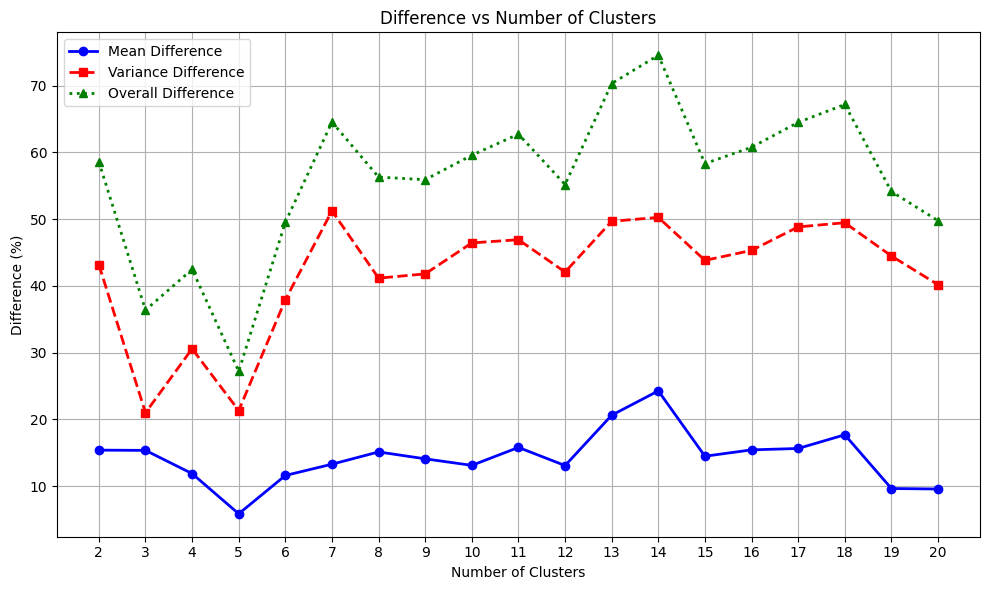

In [ ]:
# Combine all plots into one figure
plt.figure(figsize=(10, 6))

# Plot Mean Difference
plt.plot(k_values, mean_diffs, label='Mean Difference', color='blue', marker='o', linestyle='-', linewidth=2)

# Plot Variance Difference
plt.plot(k_values, variance_diffs, label='Variance Difference', color='red', marker='s', linestyle='--', linewidth=2)

# Plot Overall Difference
plt.plot(k_values, overall_diffs, label='Overall Difference', color='green', marker='^', linestyle=':', linewidth=2)

# Customize the plot
plt.xlabel('Number of Clusters')
plt.ylabel('Difference (%)')
plt.title('Difference vs Number of Clusters')

plt.xticks(range(2, 21))

plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
kmeans.fit(scaled_numeric_df_no_outliers)
clusters = kmeans.predict(scaled_numeric_df_no_outliers)

# Step 5: Select 20% of rows that are closest to the cluster centroids
# We calculate the distance of each row from the cluster center and select the closest rows
distances = kmeans.transform(scaled_numeric_df_no_outliers)
closest_rows_indices = distances.argmin(axis=1)
selected_indices = []

# Select 20% of the data from each cluster
for cluster_id in np.unique(clusters):
    cluster_indices = np.where(clusters == cluster_id)[0]
    cluster_distances = distances[cluster_indices, cluster_id]
    # Select the top 20% closest to the cluster centroid
    selected_indices += cluster_indices[cluster_distances.argsort()[:int(0.2 * len(cluster_indices))]].tolist()

# Step 6: Create the sampled DataFrame
sample_df = analysis_df.iloc[selected_indices]

# Optional: Verify statistical similarity (mean, variance, etc.) of the selected rows
sample_numeric_df = sample_df[numeric_columns]

# Calculate means and variances for the original and sample data
original_means = numeric_df.mean()
original_variances = numeric_df.var()

sample_means = sample_numeric_df.mean()
sample_variances = sample_numeric_df.var()

# Calculate differences in percentage
mean_diff_percent = ((sample_means - original_means) / original_means).abs() * 100
variance_diff_percent = ((sample_variances - original_variances) / original_variances).abs() * 100

# Display the comparison
pd.options.display.float_format = '{:,.2f}'.format

print("Mean Comparison (Percent Difference):")
print(pd.DataFrame({'Original': original_means, 'Sample': sample_means, 'Difference (%)': mean_diff_percent}))

print("\nVariance Comparison (Percent Difference):")
print(pd.DataFrame({'Original': original_variances, 'Sample': sample_variances, 'Difference (%)': variance_diff_percent}))

Mean Comparison (Percent Difference):
                       Original   Sample Difference (%)
price                      0.83     0.81           1.94
survival_duration_days 1,542.24 1,585.53           2.81
competitors               49.15    54.06          10.00
review_length            129.93   127.12           2.16
customer_engagement       34.41    33.94           1.37
rating                     4.30     4.34           0.79
num_reviews                8.16     9.17          12.36
closed                     0.05     0.03          42.10
open_date_days         2,592.45 2,559.66           1.26
observer_date_days     2,946.69 2,957.19           0.36
avg_a_food                 4.44     4.46           0.57
avg_a_service              4.42     4.42           0.15
avg_a_atmosphere           4.42     4.44           0.47

Variance Comparison (Percent Difference):
                         Original       Sample Difference (%)
price                        0.27         0.16          41.73
survival_du

In [ ]:
sample_df = numeric_df.loc[sample_numeric_df.index].reset_index(drop = True)
sample_df

,price,survival_duration_days,competitors,review_length,customer_engagement,rating,num_reviews,closed,open_date_days,observer_date_days,avg_a_food,avg_a_service,avg_a_atmosphere
0,1.00,"2,830.00",26.98,92.85,6.76,4.00,2.73,False,"1,341.00","2,983.00",4.13,3.96,4.12
1,1.00,"2,496.00",12.43,94.07,4.20,3.90,2.30,False,"1,675.00","2,983.00",3.97,4.10,3.97
2,0.00,611.00,21.67,141.56,15.19,4.20,7.29,False,"3,621.00","3,044.00",4.20,4.16,4.40
3,1.00,"2,314.00",65.51,150.31,17.96,4.30,5.17,False,"1,887.00","3,013.00",4.43,4.63,4.63
4,1.00,"2,375.00",52.96,171.96,11.77,4.30,3.52,False,"1,826.00","3,013.00",4.51,4.30,4.30
5,0.00,"1,645.00",16.25,65.66,14.36,4.80,4.76,False,"2,587.00","3,044.00",4.76,4.78,4.82
6,1.00,397.00,88.79,105.56,66.86,4.90,18.43,False,"3,835.00","3,044.00",4.86,4.91,4.86
7,1.00,"2,072.00",68.35,83.08,5.99,4.40,2.51,False,"2,099.00","2,983.00",4.39,4.52,4.42
8,1.00,"2,526.00",62.96,68.60,3.83,4.30,2.11,False,"1,706.00","3,044.00",4.50,4.38,4.54
9,1.00,"2,588.00",29.24,71.54,3.09,4.30,2.22,False,"1,644.00","3,044.00",4.60,4.35,4.35


In [ ]:
import os

sample_df.to_csv(os.path.join(dataset_path, "df_final_kmean.csv"), index=False)